In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from geopy import distance
import geopandas
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import pandas as pd
#import pygeohash
from sklearn.preprocessing import OneHotEncoder


from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, Reshape, BatchNormalization
from keras.utils import to_categorical
try:
    from keras.utils import np_utils
except:
    pass
try:
    from tensorflow.keras import utils as np_utils
except:
    pass

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder

import platform

plat = platform.system()
print("Platform: ", plat)
if ("M2" in plat) or ("arm" in plat) or ("Darwin" in plat) or ("M1" in plat) or ("M3" in plat):
    is_Apple_silicon = True
    optimizer = tf.keras.optimizers.legacy.Adam()
    print("Apple Silicon")
else:
    is_Apple_silicon = False
    #optimizer = tf.optimizers.Adam()
    optimizer = tf.keras.optimizers.legacy.Adam()
    print("Non-Apple Silicon")

error_metric_used = 'mean_squared_error'


#from keras.utils import np_utils

Platform:  Windows
Non-Apple Silicon


In [2]:
#!pip install tensorflow[and-cuda]
#!pip install keras


In [3]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

# Assignment 4 - Simple Neural Networks

For this assigment you'll do a realistic task - predicting fraud from transaction data.
### Some Things to Note

<ul>
<li> The dataset is imbalanced. See: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for some ideas
<li> The locations, time, dob all likely aren't super useful on their own, but can be made into something more useful without much code or trouble. Think about how it may be useful to represent them. The data doesn't have missing rows, so this is the main data prep portion.
<li> With respect to the above, and the other data here, we have a lot of rows of data. That means that we can generally handle data that is reasonably wide...
</ul>

### Deliverables

Your final goal is to produce a function that can be called to classify a transaction:
<ul>
<li> Please submit two .ipynb files - one where you did your work, and another that can use your model to make predictions.
<li> In that prediction file, please ensure:
    <ul>
    <li> You have a function where I can load a file, and the end result is a classificaiton matrix of your prediction accuracy.
    <li> You load a trained model. There's no training here.
    <li> Any data prep stuff that is needed for your data should be built in here. I'm going to run a test file that is the exact same setup as the training data.
    <li> I should be able to open the prediction file, load the test data, and click RUN ALL and things should work.
    <li> In addition to that, please include a short (~1-2 paragraph) description of what you did. Include anything that was innovative/different as well as a note on:
        <ul>
        <li> Any imbalanced data steps.
        <li> Treatment of the location and time variables. What did you do to them?
        <li> Model structure (layers/size)
        <li> Any optimization steps included - regularization, dropouts, feature selection, etc...
        </ul>
    </ul>
</ul>

### Grades

The grade breakdown is as follows:

<ul>
<li> Code preduces predictions - 40
<li> Accuracy - 30
<li> Explaination - 20
<li> Balance/variable transformations - 10
</ul>



In [4]:
# Load some data
df = pd.read_csv("https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv.zip")
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
trans_date_trans_time,1296675,1274791,2019-04-22 16:02:01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_num,1296675.0,NaN,NaN,NaN,417192042079726656.0,1308806447000789248.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0
merchant,1296675,693,fraud_Kilback LLC,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1296675,14,gas_transport,131659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amt,1296675.0,NaN,NaN,NaN,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9
first,1296675,352,Christopher,26669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,1296675,481,Smith,28794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,1296675,2,F,709863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
street,1296675,983,0069 Robin Brooks Apt. 695,3123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1296675,894,Birmingham,5617,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Deal with Lat/Lon

We can utilize lat/lon of the home and merchant in a useful way?

Note: I left the section headers in from when I did it. You can remove them if you want.

In [6]:
#get distance from transaction to merchant in km
df['distance'] = df.apply(lambda row: distance.distance((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1)

### Deal with Time

Can we make date/time and the date of birth into something useful?

In [7]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df["day_of_week"] = pd.to_datetime(df["trans_date_trans_time"]).dt.dayofweek
df['month'] =  df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year
#df["hour_of_day"] = pd.to_datetime(df["trans_date_trans_time"]).dt.hour
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (df['trans_date_trans_time'].dt.year - df['dob'].dt.year)

In [8]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,day_of_week,month,year,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,78.773821,1,1,2019,31
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,30.216618,1,1,2019,41
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,108.102912,1,1,2019,57
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,95.685115,1,1,2019,52
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,77.702395,1,1,2019,33


### Check Target Balance

In [9]:
pFraud = df['is_fraud'].mean()*100
print("percent fraud:", pFraud)

percent fraud: 0.5788651743883394


the percent of fraud is currently 0.58% which is extremely low

### Prepare Data


In [10]:
le = LabelEncoder()
df['merchant_encoded'] = le.fit_transform(df['merchant'])
df['category_encoded'] = le.fit_transform(df['category'])
df['state_encoded'] = le.fit_transform(df['state'])

In [11]:
columns_to_drop = [
    'trans_date_trans_time',
    'first',
    'last',
    'street',
    'city',
    'gender',
    'lat',
    'long',
    'merch_lat',
    'merch_long',
    'dob'  ,
    'job',
    'trans_num',
    'category',
    'merchant',
    'state']

df = df.drop(columns=columns_to_drop)

In [12]:
df.head(300)

,cc_num,amt,zip,city_pop,unix_time,is_fraud,distance,day_of_week,month,year,age,merchant_encoded,category_encoded,state_encoded
0,2703186189652095,4.97,28654,3495,1325376018,0,78.773821,1,1,2019,31,514,8,27
1,630423337322,107.23,99160,149,1325376044,0,30.216618,1,1,2019,41,241,4,47
2,38859492057661,220.11,83252,4154,1325376051,0,108.102912,1,1,2019,57,390,0,13
3,3534093764340240,45.00,59632,1939,1325376076,0,95.685115,1,1,2019,52,360,2,26
4,375534208663984,41.96,24433,99,1325376186,0,77.702395,1,1,2019,33,297,9,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3506042666828517,54.04,25049,630,1325389859,0,39.227891,1,1,2019,60,381,2,49
296,571844099986,909.66,40202,736284,1325389888,0,104.050231,1,1,2019,67,237,11,17
297,4045036286570100739,103.31,19310,3066,1325389940,0,50.621376,1,1,2019,91,533,4,38
298,4400011257587661852,105.38,68859,509,1325390047,0,74.977153,1,1,2019,39,650,3,29


In [13]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
cc_num,1296675.0,4.171920e+17,1.308806e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1296675.0,7.035104e+01,1.603160e+02,1.000000e+00,9.650000e+00,4.752000e+01,8.314000e+01,2.894890e+04
zip,1296675.0,4.880067e+04,2.689322e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.978300e+04
city_pop,1296675.0,8.882444e+04,3.019564e+05,2.300000e+01,7.430000e+02,2.456000e+03,2.032800e+04,2.906700e+06
unix_time,1296675.0,1.349244e+09,1.284128e+07,1.325376e+09,1.338751e+09,1.349250e+09,1.359385e+09,1.371817e+09
is_fraud,1296675.0,5.788652e-03,7.586269e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
distance,1296675.0,7.611248e+01,2.909270e+01,2.227351e-02,5.535784e+01,7.826335e+01,9.846835e+01,1.518682e+02
day_of_week,1296675.0,3.070604e+00,2.198153e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
month,1296675.0,6.142150e+00,3.417703e+00,1.000000e+00,3.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
year,1296675.0,2.019287e+03,4.522452e-01,2.019000e+03,2.019000e+03,2.019000e+03,2.020000e+03,2.020000e+03


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cc_num            1296675 non-null  int64  
 1   amt               1296675 non-null  float64
 2   zip               1296675 non-null  int64  
 3   city_pop          1296675 non-null  int64  
 4   unix_time         1296675 non-null  int64  
 5   is_fraud          1296675 non-null  int64  
 6   distance          1296675 non-null  float64
 7   day_of_week       1296675 non-null  int64  
 8   month             1296675 non-null  int64  
 9   year              1296675 non-null  int64  
 10  age               1296675 non-null  int64  
 11  merchant_encoded  1296675 non-null  int32  
 12  category_encoded  1296675 non-null  int32  
 13  state_encoded     1296675 non-null  int32  
dtypes: float64(2), int32(3), int64(9)
memory usage: 123.7 MB


### Split Data

In [15]:
y = np.array(df['is_fraud']).reshape(-1,1)
X = np.array(df.drop(columns={'is_fraud'}))
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y)
start_width = X.shape[1]
start_width


(1296675, 13) (1296675, 1)


13

In [16]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [17]:
#forgot to delete
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['is_fraud']))

### Model

In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

model = keras.Sequential()
model.add(normalizer)
model.add(InputLayer(input_shape=(start_width,)))
model.add(Dense(start_width*2, activation='relu'))
model.add(Dense(start_width, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(start_width/2, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 13)                27        
 on)                                                             
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 dense (Dense)               (None, 26)                364       
                                                                 
 dense_1 (Dense)             (None, 13)                351       
                                                                 
 dropout (Dropout)           (None, 13)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 84        
                                                        

Epoch 1/500
1557/1557 [==============================] - 3s 2ms/step - loss: 0.0862 - accuracy: 0.9940 - mean_squared_error: 0.4929 - mean_absolute_error: 0.5642 - mean_absolute_percentage_error: 554362496.0000 - val_loss: 0.0919 - val_accuracy: 0.9940 - val_mean_squared_error: 0.2580 - val_mean_absolute_error: 0.4426 - val_mean_absolute_percentage_error: 433173696.0000
Epoch 2/500
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0660 - accuracy: 0.9937 - mean_squared_error: 0.4574 - mean_absolute_error: 0.5003 - mean_absolute_percentage_error: 493459552.0000 - val_loss: 0.0491 - val_accuracy: 0.9938 - val_mean_squared_error: 0.4880 - val_mean_absolute_error: 0.5882 - val_mean_absolute_percentage_error: 581635968.0000
Epoch 3/500
1557/1557 [==============================] - 2s 2ms/step - loss: 0.0471 - accuracy: 0.9936 - mean_squared_error: 1.7101 - mean_absolute_error: 1.0101 - mean_absolute_percentage_error: 1003348672.0000 - val_loss: 0.0369 - val_accuracy: 0.9937 

INFO:tensorflow:Assets written to: fraud_detect_ct\assets


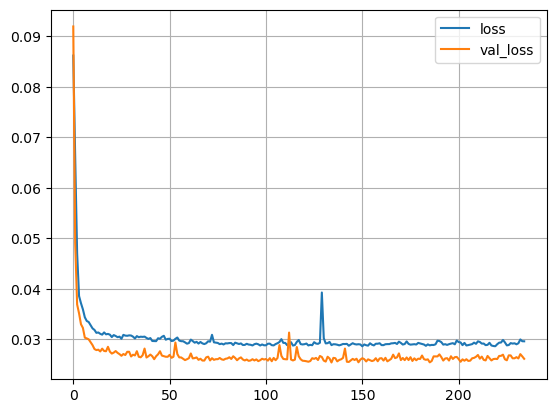

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',metrics.mean_squared_error, 
                                                                        metrics.mean_absolute_error, 
                                                                        metrics.mean_absolute_percentage_error])


BASE_EPOCHS = 100

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True) 


hist_ex = model.fit(
  X_train,
  y_train,
  epochs=500,
  batch_size=500,
  validation_split=0.2,
  callbacks=[callback],
  verbose=1
)
print(model.evaluate(X_train, y_train))
plot_loss(hist_ex)

model.save('fraud_detect_ct')
  



For the location variables I created a new column that calculated the distance from the merchant based on merc_long/lat to the person (long/lat), this is to see if there's any fraud based on if someone is far from their merchant or not.

Time variables I changed the data type to time created some new columns:
    Week of the day - to see if there is a certain day fraud happens more often on
    Hour - to see if there is a certain hour of the day that fraud happens more often on
    Age - to see if there is a certain age that fraud happens more often at

I also used label encoder for the merchant and category because when I tried to use one-hot encoder with dummies, it created too many columns and it would crash.

For the columns I dropped:

trans_date_trans_time - redundant with the other time columns I added

first - In my opinoon the name will not be that useful since it's hard to tell between a real name and a made up name

last - see above

street - I'm using zip code to generalize an error, street might be too small of an area

city - similar reasoning above

gender - does not contribute to fraud

lat - used to calculate distance column

long - used to calculate distance column

merch_lat - used to calculate distance column

merch_long - used to calculate distance column

dob - used to caluclate age

job - not relevant

trans_num - since transaction numbers only occer once, not relevant 

category - label encoded

merchant - label encoded

state - label encoded


Model Structure: I used  Dense layers starting  start width, as well as ReLu activation and Dropout after each dense layer to improve stability and gradient flow.

For optimization I used early stopping (patience = 100) to combat overfitting.

I used binary_crossentropy because it's better for problems with classes, in this case if it's fruad or not fraud.


NOTE: I orginally had epochs=6000, batch_size=6000 like in the notess but due to time constraints I changed both to 500